In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd './gdrive/My Drive/VSE_ca1/'

/content/gdrive/My Drive/VSE_ca1


In [4]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [4]:
!pip install keras==2.2.4

In [5]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Model Training

In [0]:
import maskrcnnlib

import os
import sys
import json
import datetime
import numpy as np
import skimage
import skimage.draw
import matplotlib.pyplot as plt
import imgaug as ia
from glob import glob
import random

# Root directory of the project
ROOT_DIR = os.path.abspath("gdrive/My Drive/vse_ca1/")
# Path to trained COCO weights file
COCO_WEIGHTS_PATH = os.path.join("mask_rcnn_coco.h5")

In [7]:
class favConfig(maskrcnnlib.Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    NAME = "fav"
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    BACKBONE = "resnet101"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + (bond + wire)

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    BATCH_SIZE = 8
    RPN_NMS_THRESHOLD = 0.9
    VALIDATION_STEPS = 10
    LOSS_WEIGHTS = {
      "rpn_class_loss": 1.,
      "rpn_bbox_loss": 1.,
      "mrcnn_class_loss": 2.,
      "mrcnn_bbox_loss": 1.,
      "mrcnn_mask_loss": 2.
    }

# Create configuration object
fav_training_config = favConfig()
fav_training_config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 2.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
xyd =maskrcnnlib.favDataset()
xyd.load_fav('trainData','train', 'via_train.json' )
xyd.prepare()

xydv =maskrcnnlib.favDataset()
xydv.load_fav('trainData', 'val', 'via_val.json')
xydv.prepare()

In [0]:
LEARNING_RATE = 0.0001

In [0]:
# New model training
model = maskrcnnlib.MaskRCNN(mode='training', config=fav_training_config, model_dir='./')
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

# Pretrained Model
#modeldir = 'fav20200508T0333'
#model_name = 'mask_rcnn_fav_0020.h5'
#PRETRAINED_MODEL_PATH = os.path.join( modeldir, model_name)
#model = maskrcnnlib.MaskRCNN(mode="training", config=fav_training_config, model_dir=os.path.join('./'))
#model.load_weights(PRETRAINED_MODEL_PATH, by_name=True)

model.train(xyd, xydv,
            learning_rate=LEARNING_RATE,
            epochs=15,
            layers='heads',
            augmentation= ia.augmenters.Sometimes(1,[ia.augmenters.Fliplr(1), 
                                                     ia.augmenters.Flipud(1),
                                                     ia.augmenters.Affine(scale={"y": (0.5, 2.0)},
                                                                          rotate=(-45, 45)),
                                                     ia.augmenters.Invert(0.05, per_channel=True),
                                                     ia.augmenters.Add((-10, 10), per_channel=0.5),
                                                     ia.augmenters.ContrastNormalization((0.5, 2.0), per_channel=0.5)
                                                     ]))

# Model Inference

In [9]:
class InferenceConfig(favConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    RPN_NMS_THRESHOLD = 0.9
    DETECTION_MIN_CONFIDENCE = 0.5

InferenceCfg = InferenceConfig()
InferenceCfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 2.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
modeldir = 'fav20200508T0333'
model_name = 'mask_rcnn_fav_0020.h5'

PRETRAINED_MODEL_PATH = os.path.join( modeldir, model_name)
model = maskrcnnlib.MaskRCNN(mode="inference", config=InferenceCfg, model_dir=os.path.join( './'))
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True)  


In [0]:
gt_img_masks_bond, gt_img_masks_wire,p_img_masks_bond, p_img_masks_wire, IOUs_bond, IOUs_wire = maskrcnnlib.IOU_generate(xydv, model)

In [32]:
bond_AP = np.mean(IOUs_bond)
wire_AP = np.mean(IOUs_wire)
print("Class 1 Bond Average Precision = %.4f" % bond_AP)
print("Class 2 Wire Average Precision = %.4f" % wire_AP)

print("mAP = %.4f" % np.mean([bond_AP, wire_AP]))

Class 1 Bond Average Precision = 0.7829
Class 2 Wire Average Precision = 0.2255
mAP = 0.5042


## Visualization

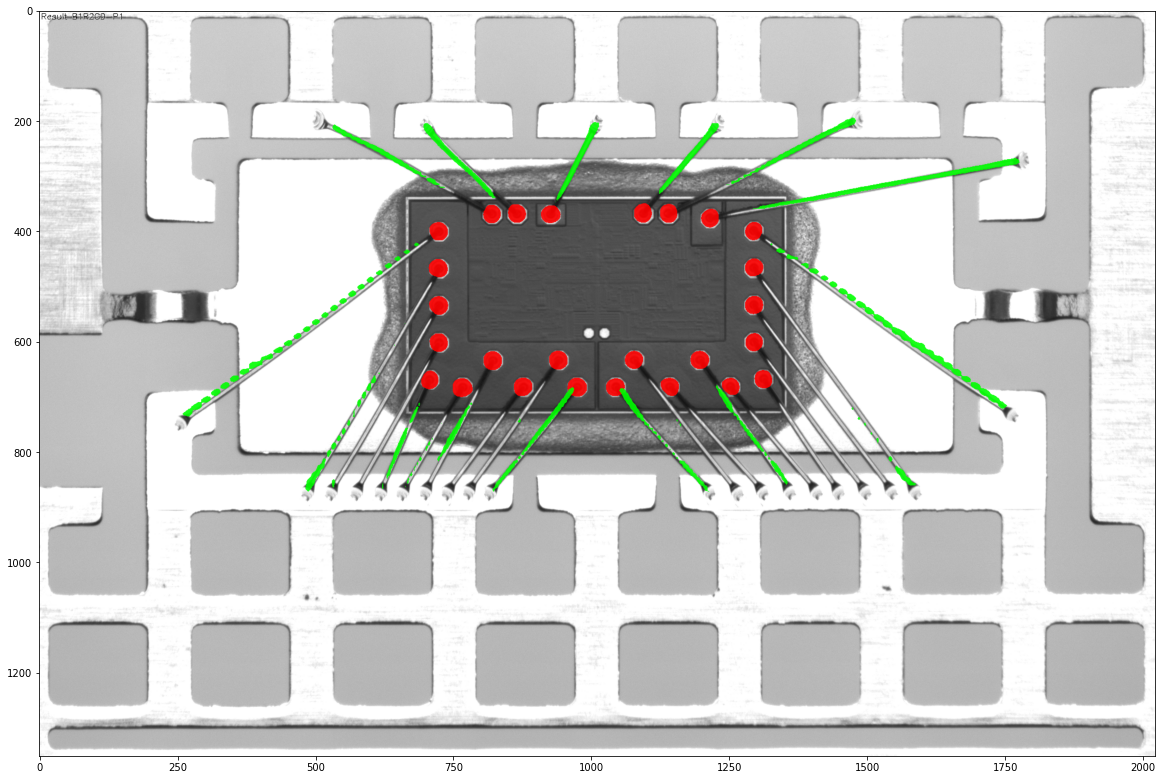

In [95]:
# visualize on original device validation set
maskrcnnlib.semanticSegmentationPlot(xydv.load_image(13), model.detect([xydv.load_image(13)], verbose=0)[0])

In [0]:
xydp =maskrcnnlib.favDataset()
xydp.load_fav('trainData', 'predict', 'via_export_json_Device1.json')
xydp.prepare()

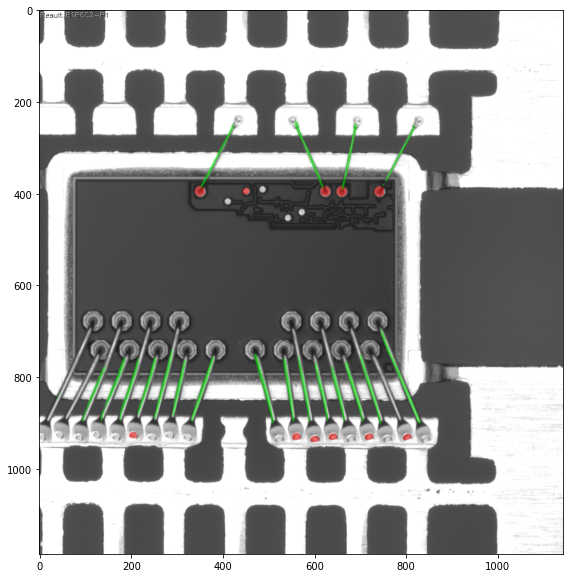

In [23]:
# visualize on other device 2
semanticSegmentationPlot(xydp.load_image(0), model.detect([xydp.load_image(0)], verbose=0)[0])